
![](https://hsto.org/files/256/a5d/ed0/256a5ded03274e0f87ccf97164c31c35.png)


# Регрессия — моя профессия


Задача, где надо спрогнозировать непрерывную переменную называется `регрессией`. Пример непрерывной переменной: цена на квартиры. Именно её прогнозированием мы сегодня и займёмся. Поехали!


## 1. Предобработка данных 

Начнём наш крестовый поход за дешёвой недвижимостью с предобработки данных. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd               # уже знакомый вам пакет для работы с таблицами
import numpy as np                # смутно знакомый вам пакет для работы с матрицами
import matplotlib.pyplot as plt   # уже знакомый вам пакет для картинок 
import seaborn as sns             # ещё один пакет для картинок 

%matplotlib inline

In [3]:
df = pd.read_csv('../../data/flat.csv', sep='\t', index_col='n')  # подгружаем табличку 
print('Размер выборки:', df.shape)                          # смотрим на её размеры 
df.head( ) # Смотрим что лежит в табличке 

Размер выборки: (2040, 10)


,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
n,,,,,,,,,,
1,81,58,40,6.0,12.5,7,1,1,1,3
2,75,44,28,6.0,13.5,7,1,0,1,6
3,128,70,42,6.0,14.5,3,1,1,1,3
4,95,61,37,6.0,13.5,7,1,0,1,1
5,330,104,60,11.0,10.5,7,0,1,1,3


__Описание переменных:__

```
n – номер квартиры по порядку
price – цена квартиры в $1000
totsp – общая площадь квартиры, кв.м.
livesp жилая площадь квартиры, кв.м.
kitsp – площадь кухни, кв.м.
dist – расстояние от центра в км.
metrdist – расстояние до метро в минутах
walk – 1 – пешком от метро, 0 – на транспорте
brick 1 – кирпичный, монолит ж/б, 0 – другой
floor 1 – этаж кроме первого и последнего, 0 – иначе.
code – число от 1 до 8, при помощи которого мы группируем наблюдения по
подвыборкам:
1. Наблюдения сгруппированы на севере, вокруг Калужско-Рижской линии
метрополитена
2. Север, вокруг Серпуховско-Тимирязевской линии метрополитена
3. Северо-запад, вокруг Замоскворецкой линии метрополитена
4. Северо-запад, вокруг Таганско-Краснопресненской линии метрополитена
5. Юго-восток, вокруг Люблинской линии метрополитена
6. Юго-восток, вокруг Таганско-Краснопресненской линии метрополитена
7. Восток, вокруг Калиниской линии метрополитена
8. Восток, вокруг Арбатско-Покровской линии метрополитена
```


Какие переменный категориальные? Какие непрерывные?

In [4]:
df.info() # Аосмотрим на информацию по типам переменных 

<class 'pandas.core.frame.DataFrame'>
Index: 2040 entries, 1 to 2040
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     2040 non-null   int64  
 1   totsp     2040 non-null   int64  
 2   livesp    2040 non-null   int64  
 3   kitsp     2040 non-null   float64
 4   dist      2040 non-null   float64
 5   metrdist  2040 non-null   int64  
 6   walk      2040 non-null   int64  
 7   brick     2040 non-null   int64  
 8   floor     2040 non-null   int64  
 9   code      2040 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 175.3 KB


In [5]:
df.isnull().sum()  # посмотрим на то есть ли в переменных пропуски

price       0
totsp       0
livesp      0
kitsp       0
dist        0
metrdist    0
walk        0
brick       0
floor       0
code        0
dtype: int64

Пропусков нет. Это хорошая новость. А что делать, если бы они были? Вспоминайте, что мы делали на лекции по предобработке данных.

Посмотрим как выглядит распределение цен. 

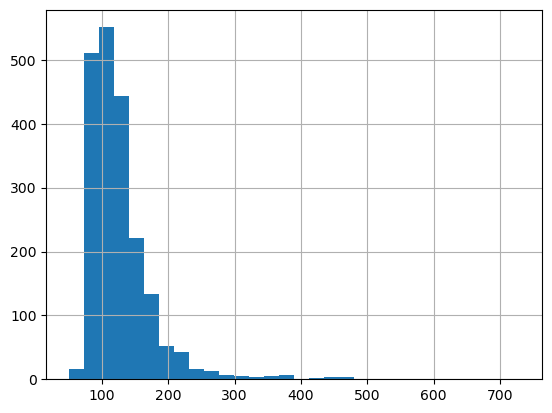

In [6]:
df.price.hist(bins=30);

У распределения цен есть проблема $-$ очень длинный хвост. В выборке встречаются квартиры с довольно большой стоимостью. Такие наблюдения называются `выбросами`. С ними нужно бороться, иначе наша модель подстроится под них. Давайте сгладим распределение цен, прологарифмировав его. Так довольно часто поступают с целевой переменной. 

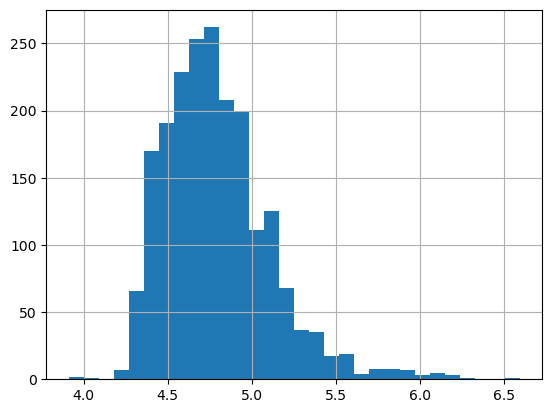

In [7]:
df['price'] = np.log(df['price'])
df.price.hist(bins=30);

Посмотрим на рспределение всех остальных признаков. Давайте обсудим, что интересного видно на картинках!

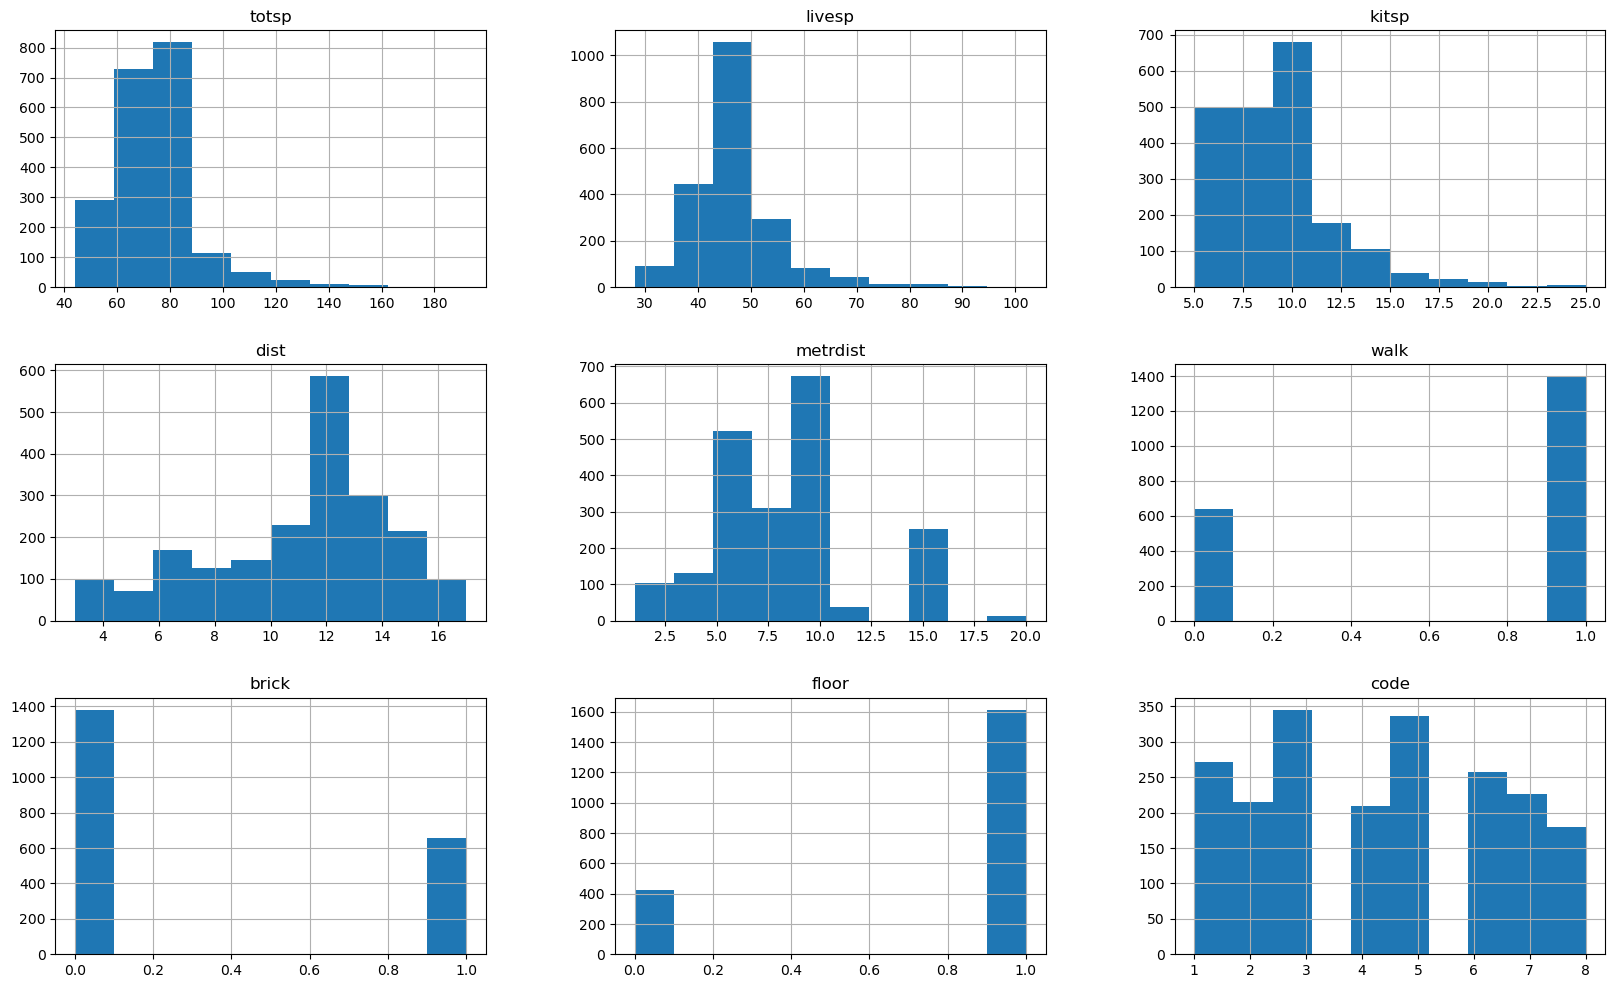

In [8]:
df.drop('price',axis=1).hist(figsize=(20, 12));

Кроме гистограммок имеет смысл взглянуть на матрицу корреляций. Что видно на ней? 

`Корреляция` (от лат. `correlatio` *«соотношение»*) — это взаимосвязь между разными показателями в статистике. Например, когда один показатель увеличивается, другой уменьшается — или тоже увеличивается. Корреляцию используют, чтобы оценить зависимость переменных друг от друга.

Если два показателя коррелируют друг с другом, выше вероятность, что они как-то связаны: например, один зависит от другого или они оба зависят от третьей переменной.

Корреляция может быть:

* положительной — когда один показатель растет, другой тоже растет;
* отрицательной — когда одна переменная растет, другая уменьшается;
* нейтральной (корреляция равна 0) — изменения не связаны друг с другом.

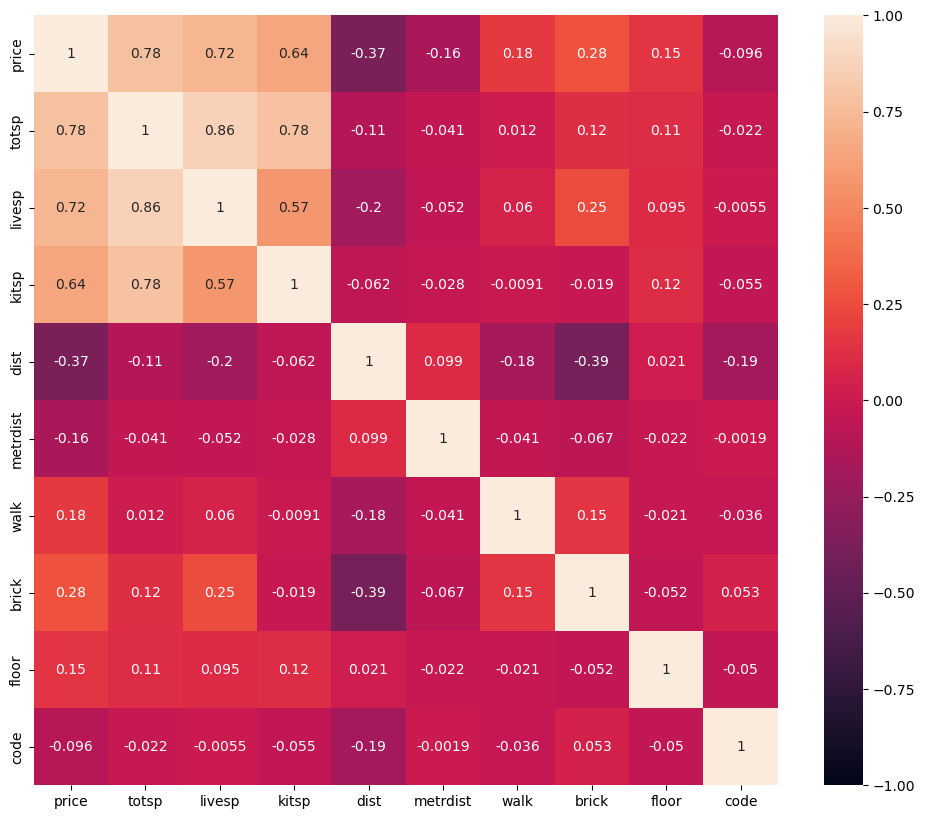

In [9]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1);

Матрица корреляции показывает, что некоторые признаки-предикторы имеют высокую взаимосвязь. Например, `площадь кухни` и `жилая площадь квартиры` линейно связаны друг с другом очень сильно, что может внести постороннюю линейную связь, на которую будет "отвлекаться" модель. Такое явление называется `мультиколлинеарностью`. И с ним при построении линейной модели необходимо бороться. Для этого достаточно избавиться от одного любого из пары скоррелированных признаков.

Найдём все пары фичей, корреляция между которыми очень сильная (выше 70%).

In [10]:
threshold = .7
high_corr_pairs = [(i, j, abs(df.corr().loc[i, j])) for i in df.corr().columns for j in df.corr().columns
                   if i != j and abs(df.corr().loc[i, j]) > threshold]
high_corr_pairs

[('price', 'totsp', 0.7785888467414176),
 ('price', 'livesp', 0.7237282409187373),
 ('totsp', 'price', 0.7785888467414176),
 ('totsp', 'livesp', 0.8622356840269008),
 ('totsp', 'kitsp', 0.7815358414748319),
 ('livesp', 'price', 0.7237282409187373),
 ('livesp', 'totsp', 0.8622356840269008),
 ('kitsp', 'totsp', 0.7815358414748319)]

Поскольку атрибут `price` является целевым (то есть его нужно будет определять и предсказывать), его удалить нельзя. Принимаю решение удалить атрибут `totsp`, поскольку в этом случае я оставлю два признака, которые являются частями удаляемого и заложены внутри него. На мой взгляд, они будут более информативными по отдельности, чем внутри `totsp`, который обозначает общую площадь квартиры.

In [11]:
df.drop(['totsp'], axis=1, inplace=True)

Высокие корреляционные связи между целевым признаком и фичами-предикторами, наоборот, должны остаться в выборке.

Ещё давайте посмотрим на облака рассеивания и успокоимся с картинками. 

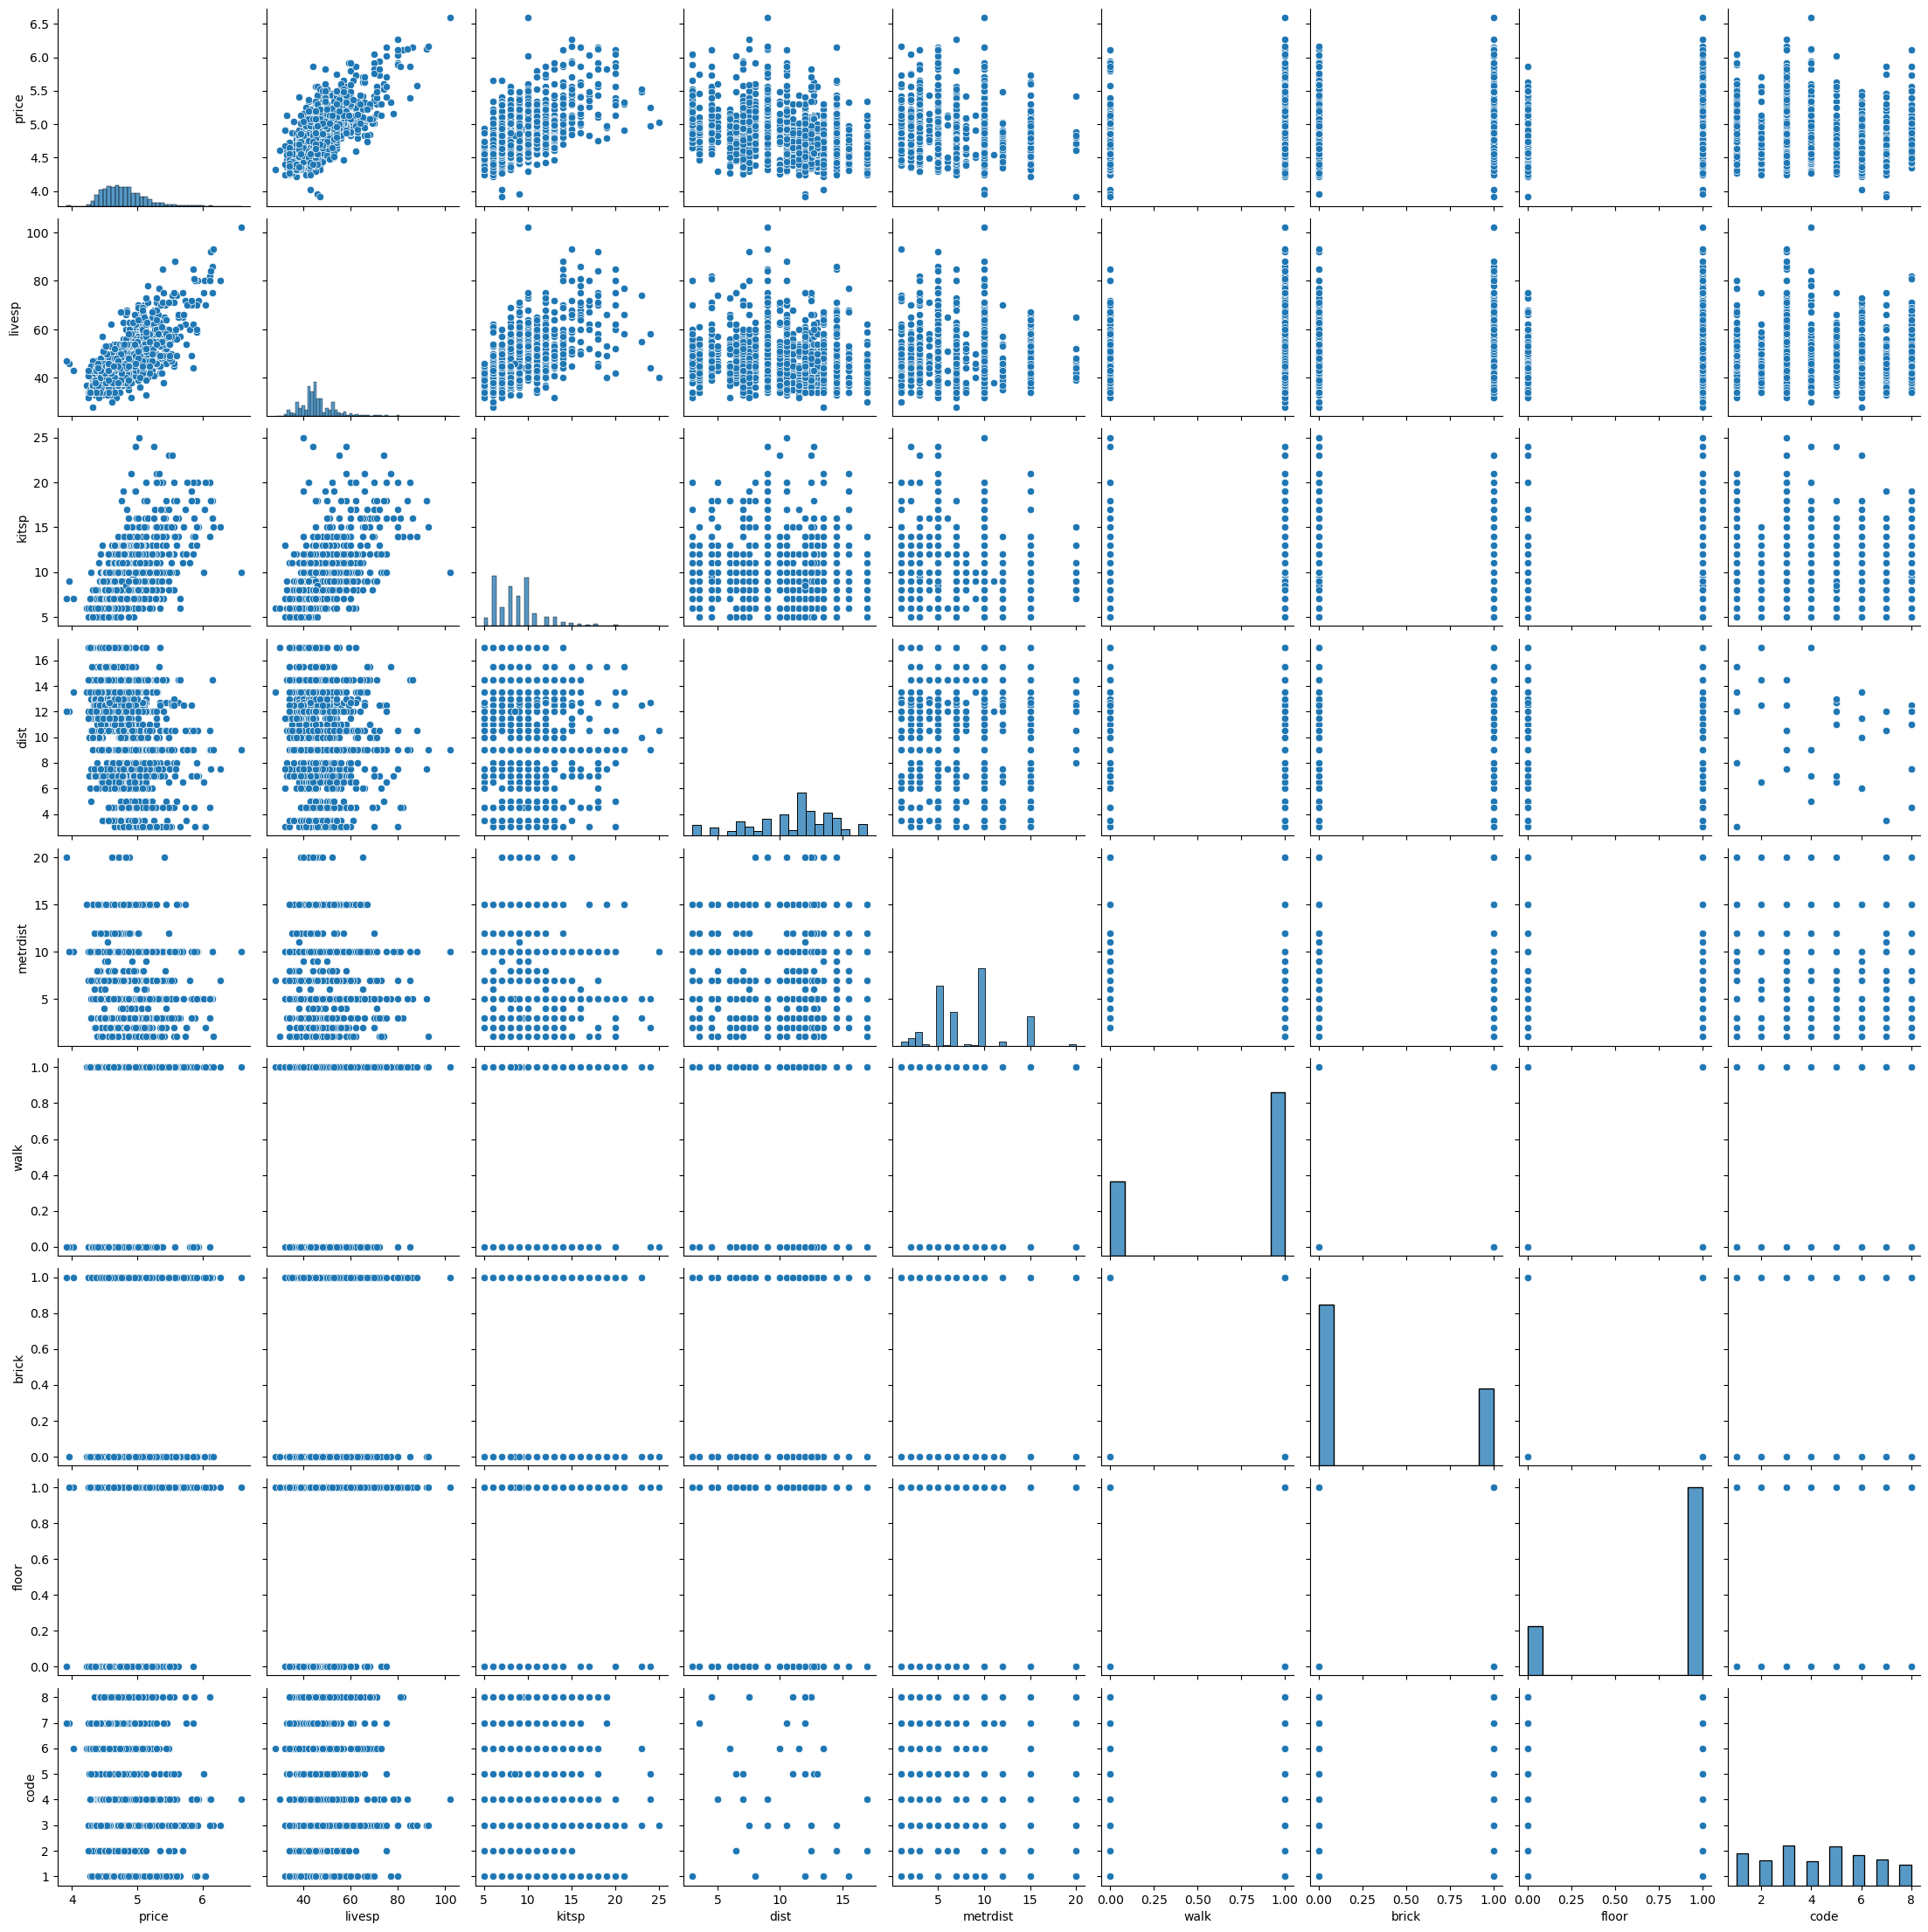

In [12]:
sns.pairplot(df);

Теперь распределение выглядит более приятно. 

Займёмся предобработкой категориальных переменных при помощи одного горячего кодирования (One Hot Encoding). При таком преобразовании категориальной переменной мы создаем столько новых столбцов, сколько различных значений этой переменной у нас было. Обычно, при этом, первый столбец убирается, чтобы не создавать линейно-зависимых столбцов. Например, если у переменной `"погода"` есть три состояния `"хорошая"`, `"средняя"` и `"нормальная"`, то после `OneHotEncoding` мы получим три столбца, где значения будут либо нулями, либо единицами, в зависимости от того, какая погода была в этом наблюдении.

## Важно
`OneHotEncoding` в общем случае тоже может привнести информацию о тестовой выборке в тренировочную в том случае, если в категориальном столбце в отложенной выборке могут содержаться новые значения. Если такая вероятность есть, то как и с другими методами препроцессинга, `OneHotEncoding` нужно обучать на трейне и использовать на тесте. 

В остальных случаях, можно воспользоваться удобной оберткой в `pandas` - `pd.get_dummies()`

In [13]:
# Сделали OHE для категориальной переменной
df_categor = pd.get_dummies(df['code'], drop_first=True, prefix='code').astype(np.int8)

# Объединили назад наши таблички
df = pd.concat([df.drop('code',axis=1),df_categor], axis=1)
df.head()

,price,livesp,kitsp,dist,metrdist,walk,brick,floor,code_2,code_3,code_4,code_5,code_6,code_7,code_8
n,,,,,,,,,,,,,,,
1,4.394449,40,6.0,12.5,7,1,1,1,0,1,0,0,0,0,0
2,4.317488,28,6.0,13.5,7,1,0,1,0,0,0,0,1,0,0
3,4.852030,42,6.0,14.5,3,1,1,1,0,1,0,0,0,0,0
4,4.553877,37,6.0,13.5,7,1,0,1,0,0,0,0,0,0,0
5,5.799093,60,11.0,10.5,7,0,1,1,0,1,0,0,0,0,0


Делим данные на тренировочные и тестовые! $30\%$ данных откладываем для тестирования качества модели. Остальные $70\%$ берём для обучения. 

In [14]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size = 0.3)

Последний предобрабатывательский штрих $-$ это `скалирование` (стандартизация непрерывных переменных).Обычно, когда обучают модель, хотят минимизировать ошибку, которую она допускает. Чаще всего эту функцию минимизируют численно. Если переменные измерены в разных шкалах (что-то в тоннах, что-то в годах и тд), алгоритм может при обучении заблудиться. Хорошо бы направить его и подтолкнуть в нужном направлении. Таким толчком является `стандартизация переменных`. 

Из каждой переменной вычитают среднее и делят на стандартное отклонение. Это очищает переменные от своих уникальных шкал и упрощает путь алгоритма к оптимальной точке. Обычно стандартное отклонение и среднее для скалирования оценивают на обучающей выборке. К тестовой применяют уже оценённый результат. Это позволяет не подглядывать в тестовую часть и не улучшать за счёт этого подглядывания прогнозы. Подглядывать $-$ нечестно! 

In [15]:
from sklearn.preprocessing import StandardScaler

# объявили скалировщик
scaler = StandardScaler()

# учим скалировщик скалировать все переменны на трейне
scaler.fit(df_train[['livesp', 'kitsp', 'dist', 'metrdist']]) 

StandardScaler()

In [16]:
# Применяем скалировщик к трейну
df_train_scale = scaler.transform(df_train[['livesp', 'kitsp', 'dist', 'metrdist']])

# Применяем скалирвощик к тесту 
df_test_scale = scaler.transform(df_test[['livesp', 'kitsp', 'dist', 'metrdist']])

In [17]:
# Заменяем значения на отскалированные
df_train[['livesp', 'kitsp', 'dist', 'metrdist']] = df_train_scale
df_test[['livesp', 'kitsp', 'dist', 'metrdist']] = df_test_scale

Все непрерывные переменные теперь выглядят проскалированными :) 

In [18]:
df_train.head()

,price,livesp,kitsp,dist,metrdist,walk,brick,floor,code_2,code_3,code_4,code_5,code_6,code_7,code_8
n,,,,,,,,,,,,,,,
747,4.488636,-0.162711,-1.051850,0.722721,0.494286,0,0,1,0,0,0,0,0,0,0
1648,5.752573,0.991353,1.112995,-2.268195,-1.615061,1,1,1,0,0,0,0,0,1,0
465,4.787492,-0.162711,0.391380,0.573175,1.812627,1,0,1,0,0,0,1,0,0,0
1458,4.317488,-1.316775,-1.051850,0.124538,0.494286,1,1,1,0,0,0,0,1,0,0
1486,4.867534,0.478435,-0.330235,-0.174554,-0.824056,0,1,1,0,0,0,0,0,1,0


In [19]:
print(df_train.shape) # Посмотрим на размеры трэйна и теста 
print(df_test.shape)  

(1428, 15)
(612, 15)


In [21]:
# Вытаскиваем цены и параметры квартир по разным переменным для удобства 

y_train = df_train.price 
y_test = df_test.price 

X_train = df_train.drop('price', axis=1)
X_test = df_test.drop('price', axis=1)

## 2. Константный прогноз 

Шаг первый. Построим `константный прогноз`. Можно обойтись и без машинного обучения $-$ просто будем говорить, что стоимость любой квартиры равна среднему значению. Это самый глупый прогноз, который мы можем сделать. Мы будм сравнивать с ним прогнозы более сложных моделей. 

In [22]:
y_mean = np.mean(y_train)                     # посчитали среднее 
y_pred_naive = np.ones(len(y_test)) * y_mean  # спрогнозировали им цену всех квартир в тестовой выборке
y_pred_naive[:5]

array([4.78664028, 4.78664028, 4.78664028, 4.78664028, 4.78664028])

## 3. Метрики качества для регрессии 

Мы сделали выше прогноз. Теперь мы хотим понять насколько он хороший. Для этого обычно используют метрики. Посмотрим на несколько таких метрик. 

In [23]:
from sklearn import metrics  # подгружаем метрики

Первой метрикой, с которой мы познакомимся, будет MAE (mean absolute error), средняя абсолютная ошибка. Она вычисляется следующим образом: 

$$ MAE = \frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y}_i|. $$

Если мы спрогнозировали, что квартира стоит 20 рублей, а она стоила 10 рублей, мы ошиблись на |10 - 20| = 10 рублей. Средняя абсолютная ошибка $-$ это средняя сумма рублей, на которую мы облажались. 

In [24]:
metrics.mean_absolute_error(y_test, y_pred_naive)

0.24876208185704582

Напомню, что мы прогнозируем логарифм цены, нам так удобнее. Ошибка выше считается в логарифмах. Если мы хотим посмотреть на ошибку в долларах, надо взять экспоненту от цен. Ниже мы можем увидеть, что в среднем ошибаемся на тридцать с лишним тысяч долларов. 

In [25]:
metrics.mean_absolute_error(np.exp(y_test), np.exp(y_pred_naive))

34.31711819868891

Второй метрикой является MSE (mean squared error), средняя квадратичная ошибка. Она вычисляется как 

$$ MSE = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2.$$

Смысл этой ошибки в том, чтобы штрафовать за большие ошибки сильнее, чем за маленькие. Если мы ошиблись на 5 долларов, то в ошибку войдёт 25. Если мы ошиблись на 10 долларов, то в ошибку войдёт 100. Чем выше ошибка, тем сильнее штраф. 

In [27]:
metrics.mean_squared_error(y_test, y_pred_naive)

0.1107679389498551

По аналогии перейдём к долларам. 

In [28]:
metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred_naive))

3482.7240641692388

Получилось многовато, не находите? Всё дело в том, что это не просто доллары, это квадратные доллары. Мы же суммировали квадраты. Неплохо было бы вернутся к обычным долларам. Для этого надо взять из MSE квадратный корень. Тогда получится новая ошибка, RMSE. 

In [29]:
np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred_naive)))

59.01460890465376

Ошибка в среднем более чем на 59 тысяч долларов. Так как более большие ошибки входят с более большим весом, вполне логично, что RMSE получилось больше, чем MAE. 

Часто для нас принципиальным является не то, на сколько денег мы ошиблись, а то на сколько процентов мы ошиблись. Метрика, которая отлавливает процентную ошибку, называется MAPE (mean absolute percentage error), средняя абсолютная процентная ошибка. 

$$
MAPE = \frac{1}{n} \sum_{i=1}^n \frac{|y_i - \hat{y}_i|}{y_i}
$$

Она часто применяется в следующих задачах: например, вы прогнозируете спрос, и вам принципиально, на сколько процентов вы ошиблись, а не абсолютное значение. Если вы предсказали  один, а в реальности было  десять - это не то же самое, что вы предсказали  тысяча, а в реальности было  тысяча  девять. С точки зрения МАЕ или MSE, это две совершенно одинаковые ошибки. А если вас интересует, сколько в среднем на сколько процентов вы ошибаетесь, то это отражает МАРЕ.

Её нам придётся реальзовать самостоятельно. Благо, это не очень трудно. 

In [30]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_test, y_pred_naive)

5.0711462857536285

Средняя ошибка примерно на $5\%$ от цены. 

Последняя метрика, с которой нам нужно познакомиться, это коэффициент детерминации, $R^2$. Он отражает то, какую долю дисперсии объясняемой переменной мы объяснили с помощью нашей модели:

$$ R^2 =1- \frac{ \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{ \frac{1}{n}\sum_{i=1}^{n} (y_i - \bar{y}_i)^2} $$

Эту метрику очень сильно любят консалтеры и аудиторы, потому что только её они и знают. На самом деле в ней нет ничего хорошего. При добавлении в модель новых переменных она всегда растёт. У неё есть ещё несколько тонких математических недостатков, о которых вы можете узнать из книг. 

In [31]:
metrics.r2_score(y_test, y_pred_naive)

-0.0022536006335132086

Не очень хороший результат. Когда $R^2$ отрицателен, то это говорит о том, что мы делаем что-то неверно.

Закинем все метрики в одну общую функцию, чтобы было удобно их печатать. 

In [32]:
def print_metrics(y_test,y_pred):
    print('MAE:', metrics.mean_absolute_error(np.exp(y_test), np.exp(y_pred)))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred))))
    print('R2:',  metrics.r2_score(y_test, y_pred))
    print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
    pass

In [33]:
print_metrics(y_test, y_pred_naive)

MAE: 34.31711819868891
RMSE: 59.01460890465376
R2: -0.0022536006335132086
MAPE: 5.0711462857536285


## 3. Строим нашу первую регрессию!

Пришло время построить линейную регрессию! Эта модель говорит, что цена на квартиру формируется в результате суммирования тех характеристик, которыми она обладает с какими-то весами

$$\hat{y} = \beta_0 + \beta_1 x_1 + ... \beta_n x_n.$$

Например, если мы оценили модель и у нас получилось, что 

$$ price = 10000 + 20 \cdot totsp,$$

то это означает, что средняя стоимость квартиры равна 10 тыс. долларам. При этом каждый дополнительный метр общей площади квартиры делает её дороже на 20 рублей. 

Для того, чтобы обучить регрессию, минимизируют одну из метрик, перечисленных в прошлом разделе. В базовой комплектации регрессии это делают с `MSE`. Такая модель обладает огромным количеством няшных статистических свойств. 

In [34]:
from sklearn.linear_model import LinearRegression

# Объявили модель
model_regression = LinearRegression()

# Обучили модель на тренировочной выборке 
model_regression.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_regr = model_regression.predict(X_test)

Посмотрим на качество прогнозов. Мы стали ошибаться меньше, чем раньше. 

In [35]:
print_metrics(y_test,y_pred_regr)

MAE: 17.979107048010384
RMSE: 32.26388260124031
R2: 0.7479710205939991
MAPE: 2.5138380189414504


Посмотрим на то, какие признаки вносят в цену наибольший вклад. 

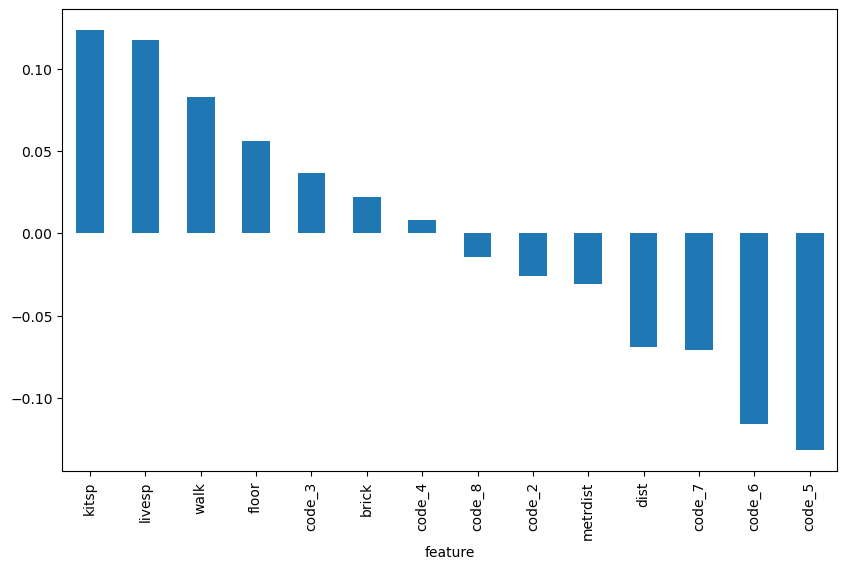

In [37]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": model_regression.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(10, 6));

## 4. Строим Lasso-регрессию 

Построим более сложную модель, LASSO-регрейссию. Фишка этой модели в том, что она зануляет лишние коэффиценты. 

In [38]:
from sklearn.linear_model import Lasso

# Объявили модель
model_simplelasso = Lasso()

# Обучили модель на тренировочной выборке 
model_simplelasso.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_lasso = model_simplelasso.predict(X_test)

Посмотрим на важность факторов для стоимости квартиры. 

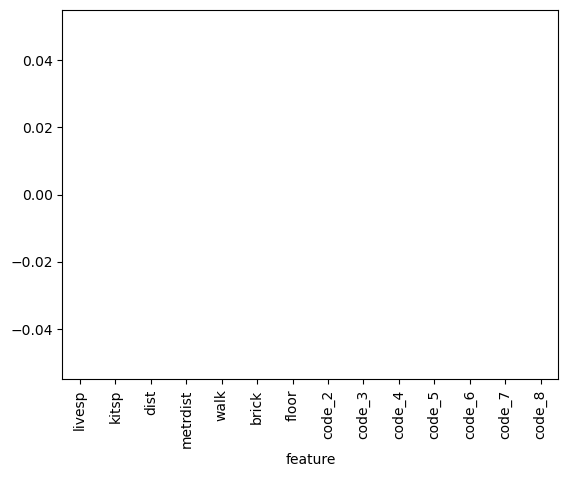

In [39]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": model_simplelasso.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar');

In [40]:
print_metrics(y_test,y_pred_lasso)

MAE: 34.31711819868891
RMSE: 59.01460890465376
R2: -0.0022536006335132086
MAPE: 5.0711462857536285


Важных факторов нет, всё занулилось. Метрики качества такие же, как при константном прогнозе. Почему такое произошло? Дело в том, что у модели есть гиперпараметр $-$ сила зануления, $\alpha$. И его нужно подбирать методом перебора. В нашей модели он стоял слишком большим. Давайте попробуем подобрать этот параметр. 

## 5. Подбор гиперпараметра для Lasso-регрессии

Будем делать перебор следующим способом: дробим тренировочную выборку на пять частей. На четырёх учим модель, на пятой прогнозируем. Смотрим на качество. И так по очереди выделяем для прогноза каждую из 5 частичек. Потом качество прогноза усредняем $-$ кросс-валидация. Для какого параметра из решётки качетство получится наибольшим, тот мы и оставим. 

In [41]:
from sklearn.model_selection import GridSearchCV

# Решётака для перебора параметра 
param_grid = {'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1, 5, 10]}

# Объявили модель 
model_lasso = Lasso() 

# Объявили перебор 
grid_cv_lasso = GridSearchCV(model_lasso, param_grid, cv = 5)
grid_cv_lasso.fit(X_train, y_train)
print('Лучшее значение параметра:', grid_cv_lasso.best_params_)

# Сделали прогнозы
y_pred_lasso = grid_cv_lasso.predict(X_test)

Лучшее значение параметра: {'alpha': 0.001}


При параметре 0.001 качество у прогнозов получилось самым хорошим. Его и берём. Посмотрим на важность переменных

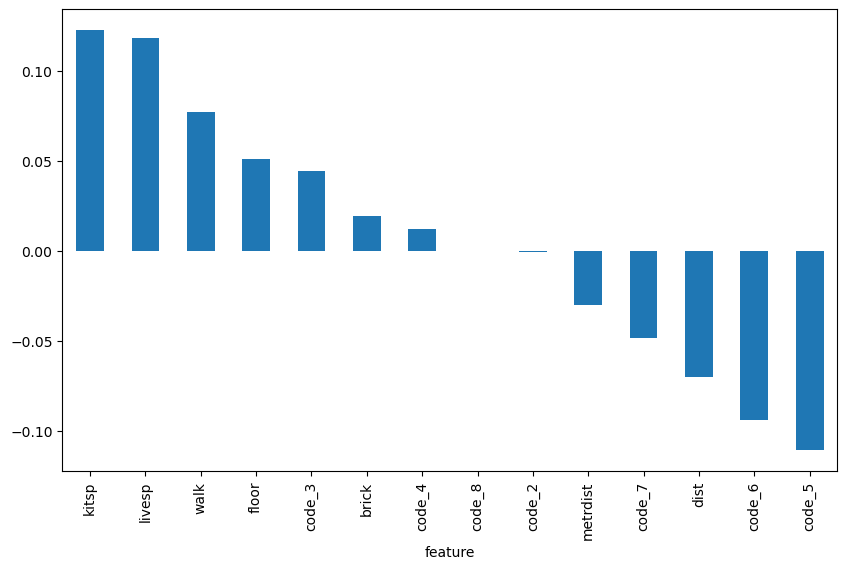

In [43]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": grid_cv_lasso.best_estimator_.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(10, 6));

И на качество модели. Оно оказывается близким к обычной регрессии. Судя по всему у нас в выборке нет лишних переменных и занулять нечего. 

In [44]:
print_metrics(y_test,y_pred_lasso)

MAE: 18.08318429555691
RMSE: 32.4297737482148
R2: 0.7464325313025124
MAPE: 2.5254287445106423


In [45]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train, y_train)
print('Лучшее значение параметра:', lasso_cv.alpha_)

# Сделали прогнозы
y_pred_lasso_cv = lasso_cv.predict(X_test)

Лучшее значение параметра: 0.0002890036788014554


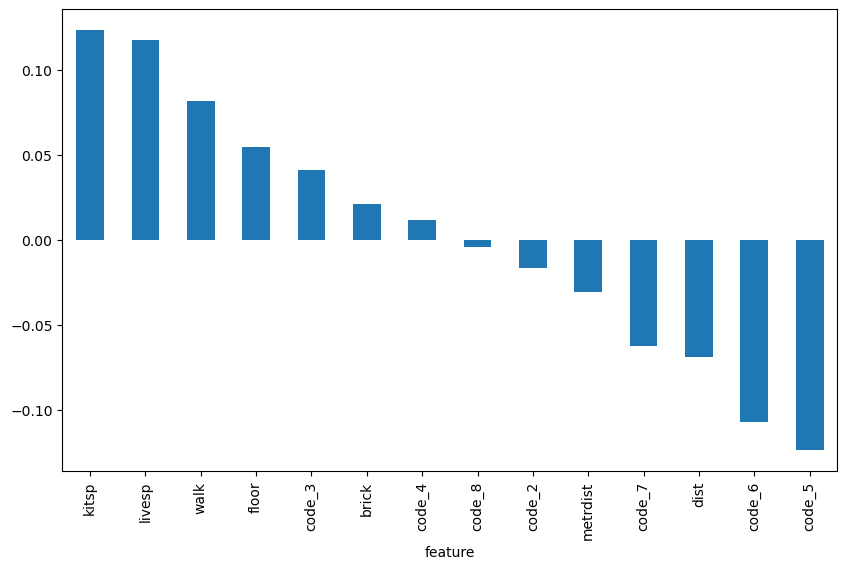

In [46]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": lasso_cv.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(10, 6));

In [47]:
print_metrics(y_test, y_pred_lasso_cv)

MAE: 18.020339642095696
RMSE: 32.32265279303038
R2: 0.7474699178475195
MAPE: 2.5182401119079625
